In [32]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import tqdm as tq
import itertools
from sklearn import metrics

# imports just to check version of libraries
import matplotlib
from tqdm.notebook import tqdm
# import tensorflow
import sklearn
import shap

warnings.simplefilter('ignore')
%matplotlib inline

# print out version of libraries
print(f"numpy=={np.__version__}" )
print(f"matplotlib=={matplotlib.__version__}")
print(f"pandas=={pd.__version__}")
print(f"tqdm=={tq.__version__}")
# print(f"tensorflow=={tensorflow.__version__}")
print(f"sckit-learn=={sklearn.__version__}")

numpy==1.21.5
matplotlib==3.6.2
pandas==1.5.2
tqdm==4.64.1
sckit-learn==1.0.2


In [2]:
ls

'~'/                                  morphologizer/
 20230320/                            ner/
 anaconda3/                           nltk_data/
 Anaconda3-2021.11-Linux-x86_64.sh    notebooks/
 attribute_ruler/                     Notebooks/
 ava/                                 openfst-1.7.2/
 AVA/                                 openfst-1.7.2.tar.gz
 ava_data_cache/                      openfst-1.8.2/
 ava-sandbox/                         openfst-1.8.2.tar.gz
 AVA-sandbox/                         parser/
 classifier.onnx                      preprocessors_data/
 config.cfg                          'prod-edrone-ava?region=eu-west-1'
 configure-jupyter-mozo-ava.sh*       run-jupyter-mozo-ava.sh*
 data/                                scikit_learn_data/
 data-cache/                          senter/
 datas_all_classes_embedding.pickle   stabs_all_classes_embedding.pickle
 datas_all_classes_input.pickle       stabs_all_classes_input.pickle
 datas_bin_embedding.pickle           stabs_bin_e

In [8]:
! cd notebooks && ls

10_autoenkodery-my-copy.ipynb
11_RNN-my-copy.ipynb
12_seq2seq-my-copy.ipynb
12_seq2seq-my-copy-old.ipynb
data_old
data.zip
eng-pol.txt
eng-pol.txt.1
env.yml
InceptionTime-Pytorch
Introduction-to-Time-Series-Clustering
Introduction-to-Time-Series-Clustering.zip
knack
Miniconda3-py37_4.8.3-Linux-x86_64.sh
models
Pipfile
skupienia
tinysleepnet
xai-survey
yasa
yasa-inspired


In [9]:
! cd notebooks && git clone https://github.com/sbobek/dsaass.git

Cloning into 'dsaass'...
remote: Enumerating objects: 10, done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 10
Unpacking objects: 100% (10/10), 44.10 MiB | 8.40 MiB/s, done.


In [14]:
with open(r"notebooks/dsaass/generated_data.p", "rb") as f:
  X_train, X_test, X_static_train, X_static_test, label_train, label_test = pickle.load(f)

print("Shape of train dataset (sequence):", X_train.shape)
print("Shape of train dataset (static):", X_static_train.shape)
print("Shape of test dataset(sequence):", X_test.shape)
print("Shape of test dataset(static):", X_static_test.shape)
print("Shape of train labels:", label_train.shape)
print("Shape of test labels:", label_test.shape)

Shape of train dataset (sequence): (8000, 15, 5)
Shape of train dataset (static): (8000, 3)
Shape of test dataset(sequence): (2000, 15, 5)
Shape of test dataset(static): (2000, 3)
Shape of train labels: (8000, 1)
Shape of test labels: (2000, 1)


In [12]:
# with open(r"notebooks/dsaass/HRM_data_labeled.p", "rb") as f:
#   X_train, X_static_train, X_test, X_static_test, label_train, label_test = pickle.load(f)
#
# print("Shape of train dataset (sequence):", X_train.shape)
# print("Shape of train dataset (static):", X_static_train.shape)
# print("Shape of test dataset(sequence):", X_test.shape)
# print("Shape of test dataset(static):", X_static_test.shape)

Shape of train dataset (sequence): (9955, 21, 20)
Shape of train dataset (static): (9955, 34)
Shape of test dataset(sequence): (2489, 21, 20)
Shape of test dataset(static): (2489, 34)


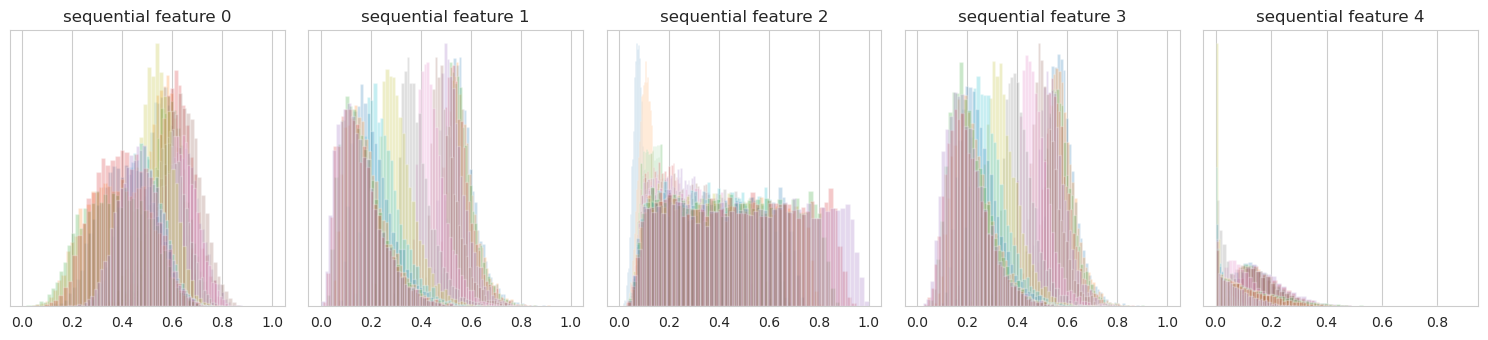

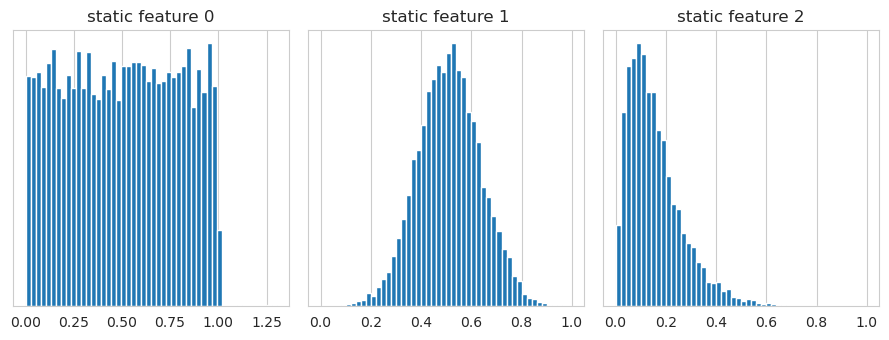

In [15]:
def plot_distributions(X, feature_ids=None):
  """
  Function which plots a histograms of data.
  In case of static data a single histogram is plotted.
  For sequential data a histogram for each feature is plotted.

  Args:
      X - numpy array with static or sequential data

  Returns:
      True value indicating that plot was successfuly made
  """
  if X.ndim == 3:
    data_type = "sequential"
  elif X.ndim == 2:
    data_type = "static"
  else:
    raise ValueError("Invalid data provided")

  if feature_ids is None:
    feature_ids = [i for i in range(X.shape[-1])]

  n = len(feature_ids)

  fig, axes = plt.subplots(nrows=1, ncols= n, figsize=(3*n, 3.5))

  for i, ax in zip(feature_ids, axes):
    ax.set_title(f"{data_type} feature {i}")
    ax.set_yticks([])
    if data_type == "sequential":
      for j in range(X.shape[1]):
        ax.hist(X[:, j, i], alpha=0.25, bins=50)
    else:
      ax.hist(X[:, i], bins=50)

  fig.tight_layout()
  fig.show()

  return True

plots_in_row = 5
for i in range(0, X_train.shape[2], plots_in_row):
  feature_ids = np.arange(i, min(i+plots_in_row, X_train.shape[2]))
  success = plot_distributions(X_train, feature_ids)

for i in range(0, X_static_train.shape[1], plots_in_row):
  feature_ids = np.arange(i, min(i+plots_in_row, X_static_train.shape[1]))
  success = plot_distributions(X_static_train, feature_ids)

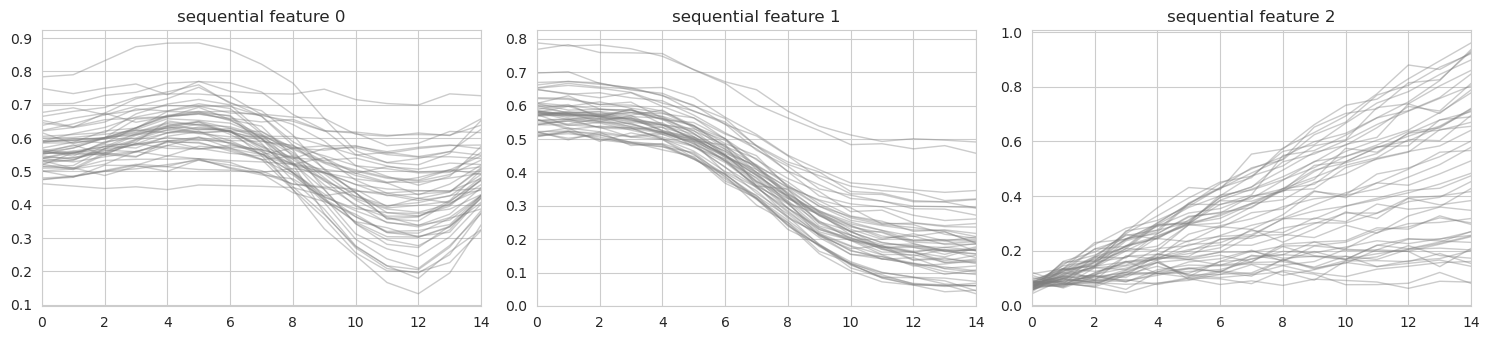

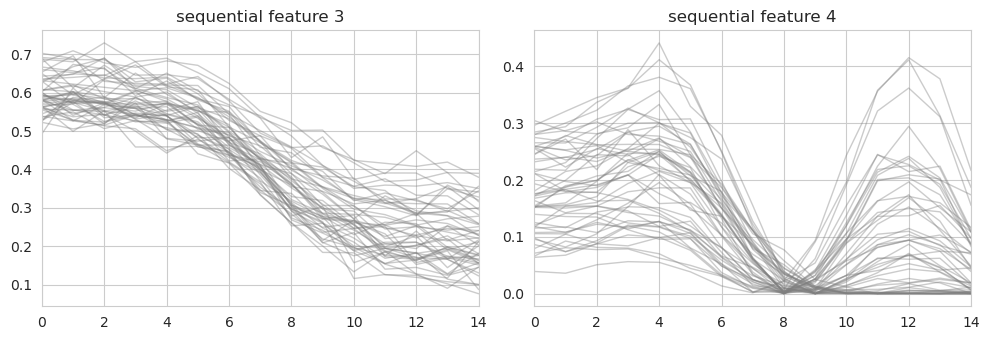

In [16]:
def plot_sequences(X, features, labels,plots_no=50, random_state=42):
  """
  Function which plots some exemplary sequences from a sequential data

  Args:
      X: numpy array with sequential data
      feature: list of feature indices to be plotted from range [0, X.shape[2]]
      plots_no: number of sequences to plot
      random_state: a random state variable

  Returns:
      True value indicating that plot was successfuly made
  """

  n = len(features)
  observations_to_plot = np.random.choice(range(X.shape[0]), size=plots_no, replace=False)
  fig, axes = plt.subplots(nrows=1, ncols= n, figsize=(5*n, 3.5))

  if n == 1:
    axes = [axes]

  for i, ax in enumerate(axes):
    f = features[i]
    ax.set_title(f"sequential feature {f}")
    for j in observations_to_plot:
      if labels[j] == 1:
        ax.plot(X[j, :, f], color="tab:red", linewidth=2, alpha=0.9)
      else:
        ax.plot(X[j, :, f], color="tab:grey", linewidth=1, alpha=0.4)
    ax.set_xlim(0, X.shape[1]-1)
  fig.tight_layout()
  fig.show()

  return True

plots_in_row = 3
for i in range(0, X_train.shape[2], plots_in_row):
  feature_ids = np.arange(i, min(i+plots_in_row, X_train.shape[2]))
  success = plot_sequences(X_train, feature_ids,label_train, plots_no=50)

In [17]:
# concatenate X and X_static into one numpy array
X_concat_train = np.concatenate([np.reshape(X_train, newshape=(X_train.shape[0], -1)),  X_static_train], axis=1)
X_concat_test = np.concatenate([np.reshape(X_test, newshape=(X_test.shape[0], -1)),  X_static_test], axis=1)

print("Shape of train dataset (concatenated):", X_concat_train.shape)
print("Shape of train dataset (concatenated):", X_concat_test.shape)

Shape of train dataset (concatenated): (8000, 78)
Shape of train dataset (concatenated): (2000, 78)


In [19]:
from sklearn.ensemble import IsolationForest


In [21]:
# define hyperparameter grid
param_grid = {
  'n_estimators': [10, 25, 50, 100],
  'max_samples': [128, 256],
  'contamination': [0.005, 0.01, 0.02, 0.05, 0.1]
}

# initialzie variables which store best model data
best_score = -1e-6
best_params = {}
best_model = None


# iterate through grid to find the best model
for values in tqdm(itertools.product(*param_grid.values()),
                   total=len(list(itertools.product(*param_grid.values())))):
  point = dict(zip(param_grid.keys(), values))
  settings = {**point}
  model = IsolationForest(**settings)
  model.fit(X_concat_train)
  labels_test_predict = model.predict(X_concat_test) < 0
  score = metrics.f1_score(label_test, labels_test_predict)

  if score > best_score:
    best_score = score
    best_params = settings
    best_model = model

# print out results
print("Best parameters:", best_params)
print("Best score:", best_score)

  0%|          | 0/40 [00:00<?, ?it/s]

Best parameters: {'n_estimators': 10, 'max_samples': 256, 'contamination': 0.1}
Best score: 0.05154639175257732


In [23]:

model = IsolationForest(n_estimators=10, max_samples=256, contamination=0.1)
model.fit(X_concat_train)

# predict the anomalies in train and test datsets
# comparison between prediction and 0 is to map the anomalies to 1 and normal observations to 0
labels_train_predict = model.predict(X_concat_train) < 0
labels_test_predict = model.predict(X_concat_test) < 0

In [24]:
def print_scores(y_true, y_predict):
  conf_matrix = pd.DataFrame(index=["Observed Normal", "Observed Anomaly"], columns=["Predicted Normal", "Predicted Anomaly"],
                             data=metrics.confusion_matrix(y_true, y_predict))


  accuracy = metrics.accuracy_score(y_true, y_predict)
  precision = metrics.precision_score(y_true, y_predict)
  recall = metrics.recall_score(y_true, y_predict)
  f1 = metrics.f1_score(y_true, y_predict)

  # print("Accuracy score:", round(accuracy, 3))
  print(conf_matrix)
  print("")
  print("Precision score:", round(precision, 3))
  print("Recall score:", round(recall, 3))
  print("F1 score:", round(f1, 3))

print_scores(label_test, labels_test_predict)

                  Predicted Normal  Predicted Anomaly
Observed Normal               1779                206
Observed Anomaly                12                  3

Precision score: 0.014
Recall score: 0.2
F1 score: 0.027


In [25]:
def to_df(ts):
  r"""Prepares a time series (Tensor/ np.ndarray) to allow feature extraction
  It reshapes the data so that each column now represents separate sequence feature.
  The id column represets separate samples, ordered correctly."""
  if isinstance(ts, np.ndarray):
    ids = np.repeat(np.arange(len(ts)), ts.shape[-1]).reshape(-1,1)
    joint_ts =  ts.transpose(0,2,1).reshape(-1, ts.shape[1])
    cols = ['id'] + np.arange(ts.shape[1]).tolist()
    df = pd.DataFrame(np.concatenate([ids, joint_ts], axis=1), columns=cols)
  elif isinstance(ts, torch.Tensor):
    ids = torch_tile(torch.arange(len(ts)), ts.shape[-1]).reshape(-1,1)
    joint_ts =  ts.transpose(1,2).reshape(-1, ts.shape[1])
    cols = ['id']+np.arange(ts.shape[1]).tolist()
    df = pd.DataFrame(torch.cat([ids, joint_ts], dim=1).numpy(), columns=cols)
  df['id'] = df['id'].astype(int)
  df.reset_index(drop=True, inplace=True)
  return df

def get_ts_features(X, y=None):
  """
  Args:
      X: np.array or torch.Tesnor of shape [samples, dimensions, timesteps].
      y: Not required for unlabeled data. Otherwise, you need to pass it.
  """
  df = to_df(X)

  ####################### YOUR CODE HERE ##########################

  #TODO: for each ID calculate statistics (min, max, stdev, variance, trend, etc.)
  df =  df.groupby('id').agg(['mean', 'max','min', 'std'], axis=1)

  #################################################################
  if y is not None:
    if y.ndim == 1: y = y.reshape(-1,1)
    for i in range(y.shape[-1]):
      df['target' if y.shape[-1] == 1 else f'target_{i}'] = y[:, i]
  return df

In [26]:
from sklearn.covariance import EllipticEnvelope
#uncomment if you have tsfresh installed
#from tsfresh.feature_extraction import extract_features, ComprehensiveFCParameters,MinimalFCParameters
df = get_ts_features(X_train)
df_ts = get_ts_features(X_test)

#uncommet when you have tsfresh installed
#df = to_df(X_train)
#df_ts = to_df(X_test)
#df= extract_features(df, column_id='id',n_jobs=13,default_fc_parameters=MinimalFCParameters())
#df_ts= extract_features(df_ts, column_id='id',n_jobs=13,default_fc_parameters=MinimalFCParameters())


X_concat_train=np.hstack((df.values, X_static_train))
X_concat_test=np.hstack((df_ts.values, X_static_test))
model =IsolationForest(n_estimators=100, max_samples=100, contamination=0.02)
model.fit(X_concat_train)

# # predict the anomalies in train and test datsets
# # comparison between prediction and 0 is to map the anomalies to 1 and normal observations to 0
labels_train_predict = model.predict(X_concat_train) < 0
labels_test_predict = model.predict(X_concat_test) < 0
print_scores(label_test, labels_test_predict)

                  Predicted Normal  Predicted Anomaly
Observed Normal               1946                 39
Observed Anomaly                15                  0

Precision score: 0.0
Recall score: 0.0
F1 score: 0.0


In [29]:
len(df)
len(df_ts)

2000

In [30]:
df_ts[0]

,mean,max,min,std
id,,,,
0,0.352575,0.550840,0.077831,0.250308
1,0.449532,0.637424,0.112093,0.248731
2,0.457125,0.692720,0.079481,0.273182
3,0.448619,0.665702,0.074321,0.267818
4,0.369274,0.568652,0.063261,0.257397
...,...,...,...,...
1995,0.371863,0.606454,0.064451,0.266656
1996,0.423402,0.650733,0.094513,0.262158
1997,0.376432,0.615097,0.058960,0.253343


In [31]:
X_train[0]

array([[0.58826416, 0.57401717, 0.08903828, 0.60489934, 0.16573479],
       [0.59375551, 0.58415288, 0.09207525, 0.58724544, 0.18093458],
       [0.60243015, 0.57887739, 0.09930725, 0.61534345, 0.18415302],
       [0.63045367, 0.54626589, 0.1295452 , 0.56590861, 0.17889293],
       [0.65295978, 0.5483938 , 0.13329402, 0.52836638, 0.20372588],
       [0.67619692, 0.48989062, 0.18351893, 0.48050998, 0.16742683],
       [0.63938869, 0.44437398, 0.22088286, 0.44073225, 0.09809786],
       [0.61879445, 0.39346684, 0.23737076, 0.41000786, 0.05268826],
       [0.56390547, 0.32479652, 0.23318165, 0.34393304, 0.00730801],
       [0.48585029, 0.2451465 , 0.26843352, 0.29054194, 0.00963448],
       [0.44471281, 0.21473905, 0.31596412, 0.28490126, 0.03287331],
       [0.38888375, 0.18662815, 0.30952972, 0.23072354, 0.07765336],
       [0.40066864, 0.15515488, 0.31754692, 0.20299527, 0.09131293],
       [0.41684425, 0.17139627, 0.35228726, 0.20686296, 0.06992608],
       [0.48595373, 0.16443662, 0.

In [36]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
  def __init__(self, input_size, input_static_size, lstm_size, dense_size, latent_size):
    super().__init__()

    # inputs
    self.lstm_input = nn.Linear(input_size[0], lstm_size)
    self.static_input = nn.Linear(input_static_size, dense_size)

    # encoder
    self.encoder_layer = nn.LSTM(input_size=input_size[0], hidden_size=lstm_size, batch_first=True)

    # static layers
    self.static_layer = nn.Sequential(
      nn.Linear(dense_size, dense_size),
      nn.ReLU(),
      nn.Dropout(p=0.1)
    )

    # latent layer (+ concatenation)
    self.latent_layer = nn.Sequential(
      nn.Linear(lstm_size + dense_size, latent_size),
      nn.ReLU()
    )
    self.repeat_layer = nn.Sequential(
      nn.Linear(latent_size, input_size[0]),
      nn.ReLU(),
      nn.Dropout(p=0.1)
    )

    # decoder
    self.decoder_layer = nn.LSTM(input_size=1, hidden_size=lstm_size, batch_first=True)

    # output layer
    self.output_layer = nn.Linear(lstm_size, input_size[1])
    self.time_distributed = nn.Sequential(
      nn.Linear(lstm_size, input_size[1]),
      nn.Sigmoid()
    )

  def forward(self, x, static_x):
    # encoder
    x = self.lstm_input(x)
    x, _ = self.encoder_layer(x)

    # static layers
    static_x = self.static_layer(self.static_input(static_x))

    # latent layer (+ concatenation)
    x = torch.cat([x[:, -1, :], static_x], dim=1)
    x = self.latent_layer(x)
    x = self.repeat_layer(x)

    # decoder
    x = x.unsqueeze(1).repeat(1, static_x.shape[1], 1)
    x, _ = self.decoder_layer(x)

    # output layer
    x = self.output_layer(x)
    x = self.time_distributed(x)

    return x

autoencoder = Autoencoder(input_size=(X_train.shape[1], X_train.shape[2]),
                          input_static_size=X_static_train.shape[1],
                          lstm_size=128,
                          dense_size=int(X_static_train.shape[1] / 1.2),
                          latent_size=int(X_train.shape[2] + int(X_static_train.shape[1]) / 1.4) )
print(autoencoder)


Autoencoder(
  (lstm_input): Linear(in_features=15, out_features=128, bias=True)
  (static_input): Linear(in_features=3, out_features=2, bias=True)
  (encoder_layer): LSTM(15, 128, batch_first=True)
  (static_layer): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (latent_layer): Sequential(
    (0): Linear(in_features=130, out_features=7, bias=True)
    (1): ReLU()
  )
  (repeat_layer): Sequential(
    (0): Linear(in_features=7, out_features=15, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (decoder_layer): LSTM(1, 128, batch_first=True)
  (output_layer): Linear(in_features=128, out_features=5, bias=True)
  (time_distributed): Sequential(
    (0): Linear(in_features=128, out_features=5, bias=True)
    (1): Sigmoid()
  )
)


In [35]:
X_train.shape[2]

5